# **Popularitätsprognose von Spotify-Songs** | EMLP-Projekt

[Link zum Datensatz](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks)

## Einleitung
Im Jahr 2020 ist Spotify mit mehr als 60 Millionen gelisteten Musiktiteln und über 320 Millionen aktiven Nutzern der größte Audio-Stremaing-Onlinedienst der Welt [https://www.spotify.com/]. Im Durchschnitt streamt jeder Nutzer pro Tag etwas mehr als eine Stunde Musik [https://de.statista.com/]. Damit ist klar, dass Spotify im Laufe der Zeit einen gigantischen Vorrat an Nutzungsdaten aufbauen konnte. Mit der Anzahl der Wiedergaben und einer Gewichtung, die berücksichtigt, wie lange die Wiedergaben in der Zeit zurückliegen, berechnet Spotify für jeden Track einen Popularity-Index, der auf einer Skala von 0 (unpopulär) bis 100 (populär) angibt, wie beliebt der Track bei den Nutzern ist.  <br>
Über die Web API  [https://developer.spotify.com/documentation/web-api/] können Metadaten, Signalanalyse-Parameter, sowie der Popularity-Index der gelisteten Tracks abgerufen werden. Der vorliegenden Datensatz beinhaltet Daten zu mehr als 170 000 Tracks, die über die Web API gesammelt wurden.  <br>
Im Rahmen des EMLP-Projektes soll untersucht werden, welche Faktoren die Popularität eines Tracks beeinflussen. Projektziel ist es, ein Regressions-Modell zu entwickeln, dass die Popularität eines Tracks auf Basis der im Datensatz erfassten Metadaten und Signalanalyse-Parametern möglichst genau vorhersagt. In diesem Projektbericht wird die Umsetzung der Datenanalyse mit Python detailliert beschrieben.

## Bibliotheken und Module

Mit den nachfolgenden Befehlen werden die benötigten Bibliotheken und Module geladen.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, learning_curve 
from sklearn.metrics import mean_squared_error, r2_score

## Pre-Processing

### Erklärung zum Datensatz

Der zu analysierende Datensatz ist wie folgt aufgebaut: Über eine Unique-ID *'id'* ist jeder Track eindeutig identifizerbar. Die kategorischen Metadaten *'name'* (Songtitel) und *'artist'* (Künstler) geben an, um welchen Track es handelt. Das Erscheinungsjahr und das Erscheinungsdatum sind in *'year'* und *'release_date'* kodiert. Neben dem Popularity-Index *'popularity'*, der die Beliebtheit des Tracks quantifiziert, enthält der Datensatz weitere numerische Parameter *'valence', 'acousticness', 'dancability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness' und 'tempo'*, die über Signalanalysealgorithmen berechnet wurden. Diese Parameter charakterisieren die psychoakustischen Eigenschaften der Tracks. Darüber hinaus enthält der Datensatz die binären Daten *'mode'* (0: Moll/1: Dur) und *'explicit'* (0: jugendfrei/1: nicht jugendfrei) sowie die kategorischen Daten *'key'* (Tonart). 
In der nachfolgenden Tabelle sind alle im Datensatz enthaltenen Werte, ihr Datentyp, sowie eine detaillierte Beschreibung aufgelistet.

<table>
  <thead>
    <tr>
      <th>Key</th>
      <th>Value Type</th>
      <th>Value Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>popularity</td>
      <td>int</td>
      <td>Popularity is based on (1) the total number of plays compared to other tracks and (2) how recent those plays are.</td>
    </tr>
    <tr>
      <td>valence</td>
      <td>float</td>
      <td>A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).</td>  
    </tr>
    <tr>
      <td>year</td>
      <td>int</td>
      <td>The release year of track.</td>  
    </tr>
    <tr>
      <td>acousticness</td>
      <td>float</td>
      <td>	A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.</td>  
    </tr>
    <tr>
      <td>artists</td>
      <td>float</td>
      <td>The list of artists credited for production of the track.</td>  
    </tr>
    <tr>
      <td>dancability</td>
      <td>float</td>
      <td>Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.</td>  
    </tr>
    <tr>
      <td>duration_ms</td>
      <td>int</td>
      <td>The duration of the track in milliseconds.</td>  
    </tr>
    <tr>
      <td>energy</td>
      <td>float</td>
      <td>Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.</td>  
    </tr>
    <tr>
      <td>explicit</td>
      <td>int</td>
      <td>The binary value whether the track contains explicit content or not.</td>  
    </tr>
    <tr>
      <td>id</td>
      <td>string</td>
      <td>The Spotify ID for the track.</td>  
    </tr>
    <tr>
      <td>instrumentalness</td>
      <td>float</td>
      <td>Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.</td>  
    </tr>
    <tr>
      <td>key</td>
      <td>int</td>
      <td>The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation as integers in between 0 and 11. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.</td>  
    </tr>
    <tr>
      <td>liveness</td>
      <td>float</td>
      <td>Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.</td>  
    </tr>
    <tr>
      <td>loudness</td>
      <td>float</td>
      <td>The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. </td>  
    </tr>
    <tr>
      <td>mode</td>
      <td>int</td>
      <td>The binary value representing whether the track starts with a major (1) chord progression or not (0).</td>  
    </tr>
    <tr>
      <td>name</td>
      <td>string</td>
      <td>The name of the track.</td>  
    </tr>
    <tr>
      <td>release_date</td>
      <td>string</td>
      <td>The date of release of the track in yyyy-mm-dd, yyyy-mm, or even yyyy format.</td>  
    </tr>
    <tr>
      <td>speachiness</td>
      <td>float</td>
      <td>	Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.</td>  
    </tr>
    <tr>
      <td>tempo</td>
      <td>int</td>
      <td>The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.</td>  
    </tr>   
  </tbody>
</table>

### Datenimport

Die Daten werden mit *pd.read_csv()* importiert.

In [2]:
df = pd.read_csv('data.csv') # Datenimport

### Erste Untersuchung des Datensatzes

Um einen Überblick über die Struktur des Datensatzes zu gewinnen, werden die Befehle *df.info(), df.head(), df.tail()* und *df.describe()* benutzt. 

In [3]:
df.info() # Allgemeine Infos zum Datensatz

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [4]:
df.head(3) # Die ersten drei Einträge werden ausgegeben

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339


In [5]:
df.tail(3) # Die letzten drei Einträge werden ausgegeben

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
170650,0.637,2020,0.10100,['MAMAMOO'],0.634,211280,0.858,0,4BZXVFYCb76Q0Klojq4piV,0.000009,4,0.258,-2.226,0,AYA,76,2020-11-03,0.0809,91.688
170651,0.195,2020,0.00998,['Eminem'],0.671,337147,0.623,1,5SiZJoLXp3WOl3J4C8IK0d,0.000008,2,0.643,-7.161,1,Darkness,70,2020-01-17,0.3080,75.055
170652,0.642,2020,0.13200,"['KEVVO', 'J Balvin']",0.856,189507,0.721,1,7HmnJHfs0BkFzX4x8j0hkl,0.004710,7,0.182,-4.928,1,Billetes Azules (with J Balvin),74,2020-10-16,0.1080,94.991


In [6]:
df.describe() # Einige statistische Infos zum Datensatz (Mittelwert, Quantile, ...)

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
count,170653.000000,170653.000000,170653.000000,170653.000000,1.706530e+05,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000
mean,0.528587,1976.787241,0.502115,0.537396,2.309483e+05,0.482389,0.084575,0.167010,5.199844,0.205839,-11.467990,0.706902,31.431794,0.098393,116.861590
std,0.263171,25.917853,0.376032,0.176138,1.261184e+05,0.267646,0.278249,0.313475,3.515094,0.174805,5.697943,0.455184,21.826615,0.162740,30.708533
min,0.000000,1921.000000,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,0.317000,1956.000000,0.102000,0.415000,1.698270e+05,0.255000,0.000000,0.000000,2.000000,0.098800,-14.615000,0.000000,11.000000,0.034900,93.421000
50%,0.540000,1977.000000,0.516000,0.548000,2.074670e+05,0.471000,0.000000,0.000216,5.000000,0.136000,-10.580000,1.000000,33.000000,0.045000,114.729000
75%,0.747000,1999.000000,0.893000,0.668000,2.624000e+05,0.703000,0.000000,0.102000,8.000000,0.261000,-7.183000,1.000000,48.000000,0.075600,135.537000
max,1.000000,2020.000000,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.970000,243.507000


### Bereinigung des Datensatzes

Mit den folgenden Code-Zeilen werden die Werte der Spalte *'duration_ms'* in Minuten umgerechnet, was die Verständlichkeit fördert. Tracks mit mehr als 12 min Dauer werden aus dem Datensatz entfernt, da es sich bei diesen mit großer Wahrscheinlichkeit um Hörbücher, Podcasts, Live-Aufnahmen o. Ä. handelt und nicht um Songs. 
Mit *df.duplicated()* Datensatz wird auf Doubletten untersucht. Der Befehl *df.isnull()* wird verwendet um fehlende Daten aufzuspüren.
Die Spalten *'release_date'* und *'id'* werden mit *df.drop()* aus dem DataFrame entfernt, da sie keine sinnvollen Informationen beitragen.

In [7]:
df.duration_ms = df.duration_ms/60000 # Umrechnung von ms in min
df = df.rename(columns={'duration_ms' : 'duration_min'}) # Umbenennen der Spalte 'duration_ms' in 'duration_min'
df = pd.DataFrame(df[df['duration_min'] < 12]) # Behalte alle Tracks mit <= 12 min Dauer
#df.head()

In [8]:
n_doubletten = df.duplicated(subset = None, keep = 'first').sum() # Test auf doppelte Einträge
print(f'Der Datensatz enthält {n_doubletten} Doubletten.')

Der Datensatz enthält 0 Doubletten.


In [9]:
n_isnan = df.isnull().sum().sum() # Test auf NaN-Einträge
print(f'Der Datensatz enthält {n_isnan} NaN-Werte.')

Der Datensatz enthält 0 NaN-Werte.


In [10]:
df = df.drop(labels = ['release_date', 'id'], axis = 1) # 'Release_date' ist in unerschiedlicher Genauigkeit angegeben und doppelt sich mit 'year' -> drop!
# 'id' wird ebenfalls gedroppt, da uninformativ

### Split in numerische Daten und String-Daten

Der Datensatz wird für die weiteren Untersuchungen in numerische Daten und String-Daten aufgeteilt.

In [11]:
df_str = pd.DataFrame(data = df, columns = df.columns[df.dtypes == 'object'], index = df.index) # Neuer df mit String-Daten
df_num = pd.DataFrame(data = df, columns = df.columns[df.dtypes != 'object'], index = df.index) # Neuer df mit numerischen Daten

### Normalisierung der numerischen Daten

Damit in den Machine-Learning-Modellen alle Features mit der selben Gewichtung eingehen, werden die numerischen Daten auf das Intervall [0, 1] normalisiert. 

In [12]:
x = df_num.values # Gibt Daten als NumPy-Array zurück
min_max_scaler = preprocessing.MinMaxScaler() # Initialisierung des MinMaxScaler
x_scaled = min_max_scaler.fit_transform(x) # [0, 1]-Normalisierung mit Sklearn
df_num = pd.DataFrame(x_scaled, columns = df_num.columns, index = df_num.index) 

### Datenvisualisierung

Im Folgenden werden die Daten des Spotify-Datensatzes visualisiert, um erste qualitative Zusammenhänge zu untersuchen.

#### Histogramme

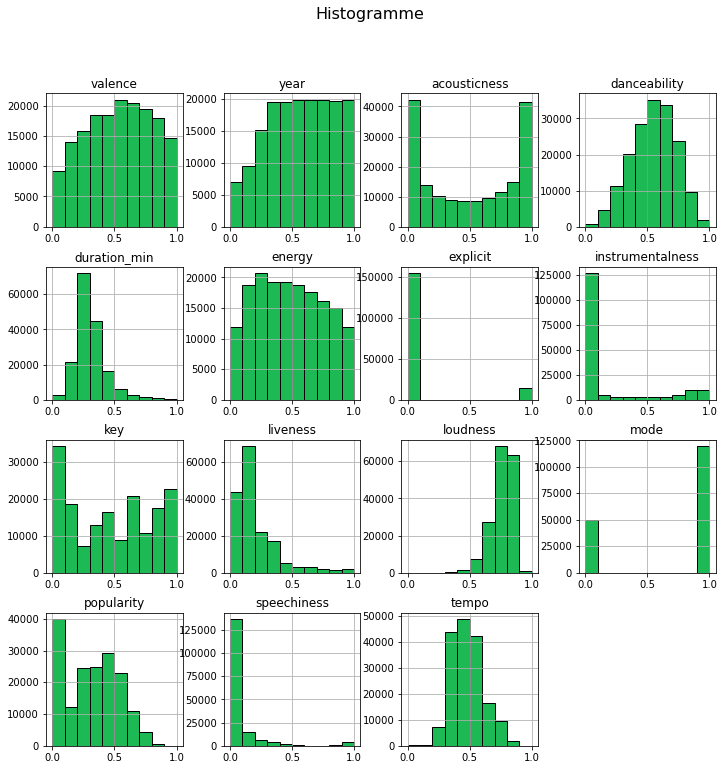

In [13]:
# Histogramme
g = df_num.hist(figsize = (12, 12), color = '#1DB954', ec = "black") # Zeigt die Verteilung der Werte; #1DB954 für Spotify-Grün
plt.suptitle('Histogramme', size = 16)
plt.show()

Auffälligkeiten:
- *'valence', 'year' und 'energy'* sind in etwa gleichverteilt
- *'dancability', 'duration', 'loudness' und 'tempo'* sind ungefähr normalverteilt
- *'acousticness', 'instrumentalness', 'explicit'* und *'mode'* zeigen eine stark zweiseitige Verteilung
- *'speechiness'* ist für fast alle Tracks sehr niedrig, d. h. bei den meisten Tracks handelt es sich um Musikstücke

#### Korrelationsmatrix

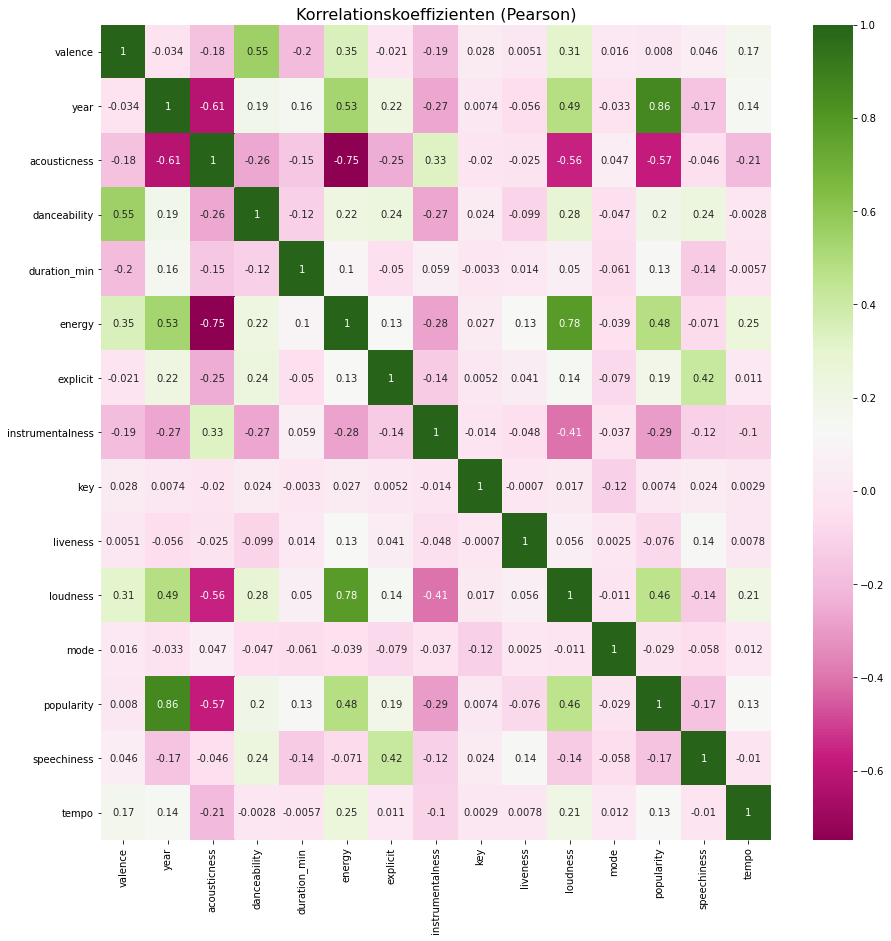

In [14]:
# Heatmap mit Korrelationskoeffizienten
plt.figure(figsize = (15, 15))
ax = plt.axes()
sns.heatmap(df_num.corr(), annot = True, cmap = 'PiYG', ax = ax)
ax.set_title('Korrelationskoeffizienten (Pearson)', size = 16)
plt.show()

Auffälligkeiten:
- *'year'* ($r = +0.86$), *'energy'* ($r = +0.48$) und *'loudness'* ($r = +0.46$) haben die stärkste positive Korrelation mit der *'popularity'*
- *'acousticness'* ($r = -0.57$), *'instrumentalness'* ($r = -0.29$) und *'speechiness'* ($r = -0.17$) haben die stärkste negative Korrelation mit der *'popularity'*

Fazit: Je aktueller, und energiegeladener (Tempo/Lautstärke/...) ein Track ist, desto populärer ist er. Je größer der Anteil an akustischen Instrumenten oder Sprache (nicht Gesang) ist, desto unpopulärer ist ein Track.

#### Pairplot

Basierend auf den Ergebnissen der Korrelationsanalyse wurden die Verteilungen der Daten für *'popularity'*, *'year'*, *'energy'*,  *'acousticness'* und *'instrumentalness'* mit *sns.pairplot()* noch eingehender Untersucht.

<Figure size 1800x1800 with 0 Axes>

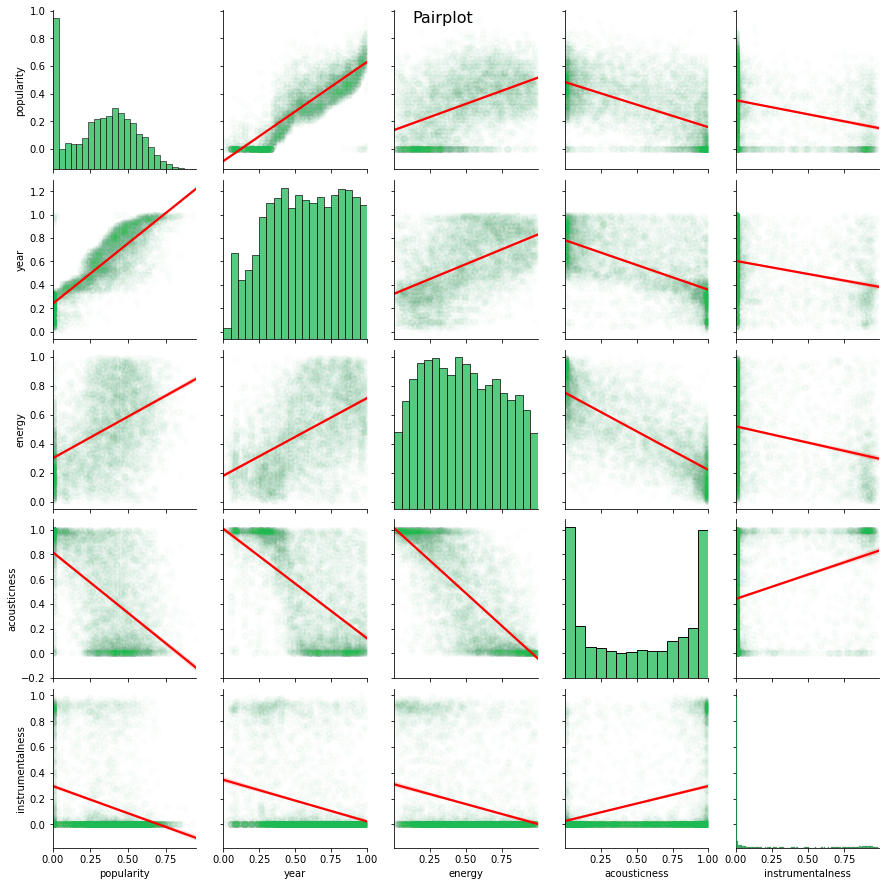

In [15]:
# Pairplot
plt.figure(figsize = (25, 25))
g = sns.pairplot(df_num[['popularity','year','energy','acousticness','instrumentalness']].sample(5000), kind = 'reg', plot_kws = {'line_kws':{'color':'red'}, 'scatter_kws': {'color':'#1DB954','alpha': 0.01}}, diag_kws = {'color':'#1DB954'})
g.fig.suptitle('Pairplot', size = 16)
plt.show()

Auffälligkeiten:
- Die Korrelation zwischen *'year'* und der *'popularity'* ist klar ersichtlich.
- Die Korrelation zwischen *'energy'* und *'popularity'* ist schwach ersichtlich.
- Der Zusammenhang der *'popularity'* und *'acousticness'*, bzw. *'instrumentalness'* ist eher binär.

## String-Daten: Target Encoding

Die String-Daten *'artist'* und *'name'* können nicht direkt für das Machine Learning verwendet werden, da es sich nicht um numerische Daten handelt. In diesem Kapitel werden die Daten daher mit einem Target-Encoding in numerische Daten umgewandelt. Die *'artist'*-Werte werden mit der mittleren Popularität der Tracks eines Künstlers (*'artist_popularity'*) ersetzt, die *'name'*-Strings werden aufgeteilt in einzelne Wörter, für die jeweils die mittlere Popularität berechnet wird. Auf Basis dieser Werte wird ein Titel Popularity-Index für jeden Track zusammengesetzt. <br>
**Die Vorgehensweise ist nicht unproblematisch, da durch das Target Encoding die Input- und Target-Daten statistisch voneinander abhängig gemacht werden.**

### Künstler Popularity-Index

Für die Berechnung des Künstler Popularity-Index wird für jeden Künstler der Mittelwert der Popularität seiner Tracks gebildet.

In [16]:
df_art = pd.concat([df_str['artists'], df_num['popularity']], axis = 1) # Neuer df mit artist und popularity

In [17]:
df_art['popularity'] = df_art['popularity'].groupby([df_art['artists']]).transform('mean') # Ersetzen der popularity mit mittlerer popularity des artist
df_art = df_art.rename(columns={'popularity' : 'artists_popularity'}) # Umbenennen der Spalte 'popularity' in 'artist_popularity'
df_art = pd.concat([df_art, df_num['popularity']], axis = 1) # Hinzufügen der 'popularity' für Plot 

In [18]:
#df_art.head()

<Figure size 1080x1080 with 0 Axes>

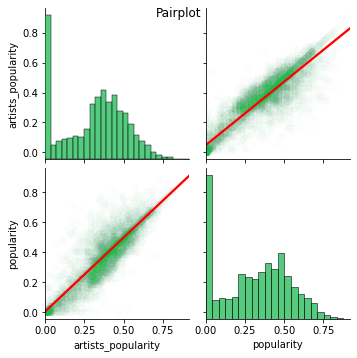

In [19]:
# Pairplot von 'popularity' und 'artists_popularity'
plt.figure(figsize=(15, 15))
g = sns.pairplot(df_art.sample(5000), kind = 'reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'color':'#1DB954','alpha': 0.01}}, diag_kws={'color':'#1DB954'})
g.fig.suptitle('Pairplot')
plt.show()

Aus dem Pairplot geht hervor, dass *'popularity'* und *'artists_popularity'* wie relativ linear voneinander abhängen. Die Popularität des Künstlers korreliert stark mit der Popularität.

Mit df.sort_values() kann die *'artists_popularity'* absteigend geordnet werden.

In [20]:
df_art.sort_values(by = 'artists_popularity', ascending = False).head(n = 10)

,artists,artists_popularity,popularity
19611,"['Bad Bunny', 'Jhay Cortez']",1.00,1.00
19606,"['24kGoldn', 'iann dior']",0.99,0.99
19608,"['Cardi B', 'Megan Thee Stallion']",0.96,0.96
19620,"['Justin Bieber', 'benny blanco']",0.95,0.95
19720,"['Sech', 'Daddy Yankee', 'J Balvin', 'ROSALÍA'...",0.94,0.94
19655,"['Joel Corry', 'MNEK']",0.94,0.94
19609,"['Drake', 'Lil Durk']",0.93,0.93
19621,['Ritt Momney'],0.93,0.93
19672,"['J Balvin', 'Tainy', 'Dua Lipa', 'Bad Bunny']",0.92,0.92
38452,"['Manuel Turizo', 'Rauw Alejandro', 'Myke Towe...",0.92,0.92


Bei der Betrachtung der geordneten Liste fällt auf, dass Kollaborationen der Popularität eines Songs sehr zuträglich sind. *"Bad Bunny x Jhay Cortez", "24kGoldn x Iann Dior", "Cardi B x Megan Thee Stallion", "Justin Bieber x Benni Blanco"* und *"Sech x Daddy Yankee x J Balvin x Rosalía Farruko"* sind die 5 populärsten Kollabs. 

### Titel Popularity-Index

Für die Berechnung des Titel Popularity-Index werden die einzenlnen Titel-Strings zunächst anhand der Leerzeichen in einzelne Wörter getrennt. Für jedes Wort wird der Mittelwert seiner Popularität anhand aller seiner *'popularity'*-Werte berechnet. Um den finalen Index zu erhalten werden für jeden Titel die mittleren Popularitäten seiner Bestandteile addiert und durch die Anzahl der Bestandteile dividiert.

In [21]:
df_nam = pd.concat([df_str['name'], df_num['popularity']], axis = 1) # Neuer df mit name und popularity

In [22]:
df_nam['name'] = df_nam.name.astype(str) # Umwandlung in String-Format
df_nam = df_nam.assign(name = df_nam.name.str.split()) # name-String wird anhand von Leerzeichen in Liste getrennt
df_nam['name'] = df_nam['name'].map(lambda a: tuple(a)) # Umwandlung in Tupel
#df_nam.head()

In [23]:
df_par = df_nam.explode('name') # Auftrennen des df_nam in einzelne name-Bestandteile und zugehöriger popularity
#df_par.head(n=10)

In [24]:
df_par['popularity'] = df_par['popularity'].groupby([df_par['name']]).transform('mean') # Ersetzen der popularity mit mittlerer popularity des name-Bestandteil
df_par = df_par.assign(count = df_par['popularity'].groupby([df_par['name']]).transform('count')) # Zähle Erscheinungen des Namensbestandteils
df_par = df_par.rename(columns={'popularity' : 'name_part_popularity'}) # Umbenennen der Spalte 'popularity' in 'name_part_popularity'
df_par = df_par.drop_duplicates(subset='name') # Entfernen der Duplikate

Mit df.sort_values() kann die *'name_part_popularity'*, also die Popularität der Titelbestandteile absteigend geordnet werden.

In [25]:
df_par.sort_values(by = 'name_part_popularity', ascending = False).head(n = 10)

,name,name_part_popularity,count
19611,Dakiti,1.00,1
19608,WAP,0.96,1
19620,benny,0.95,1
19620,blanco),0.95,1
19623,broke,0.95,1
19655,MNEK),0.94,1
19624,Therefore,0.93,1
19672,DIA,0.92,1
19672,(ONE,0.92,1
19672,DAY),0.92,1


Titel von populären Tracks (*'Dakiti'*) und Namensbestandteile von populären Künstlern *'WAP', 'Benny', 'Blanco', ...* führen das Ranking der Popularität von Titel-Bestandteilen an. *'Broke', 'day', 'dia' und 'popstar'* sind ebenfalls prominente Bestandteile. Problem: Einzigartige Titel werden bei dieser Berechnungsmethode überbewertet, da keinerlei statistische Mittelung stattfindet. Um dieses Problem zu umgehen, wird im Folgenden der Count-Value in der Analyse mit berücksichtigt.

In [26]:
df_par['name_part_popularity'] = 0.6*df_par['name_part_popularity']+0.4*df_par['count']/max(df_par['count']) # Count-Value wird berücksichtigt

In [27]:
df_par.sort_values(by = 'name_part_popularity', ascending = False).head(n = 10)

,name,name_part_popularity,count
19611,Dakiti,0.600013,1
19608,WAP,0.576013,1
19620,blanco),0.570013,1
19623,broke,0.570013,1
19620,benny,0.570013,1
19655,MNEK),0.564013,1
19624,Therefore,0.558013,1
19672,DIA,0.552013,1
19672,DAY),0.552013,1
19672,(ONE,0.552013,1


In [28]:
#Hier wird der Titel-Popularitätsindex berechnet und in ein Excel-File exportiert, dass schnell importiert werden kann (Runtime ca. 2h!)
#def name_popularity(x, df_nam, df_par):
#    pop = 0
#    n = 0
#    for part in x:
#        pop = pop + df_par['name_part_popularity'][df_par['name'] == part].values
#        n += 1
#    return str(pop/n)   
#
#df_nam['name'] = df_nam['name'].apply(lambda x: name_popularity(x, df_nam, df_par))
#df_nam.to_excel("title_popularity.xlsx")

In [29]:
df_nam = pd.read_excel("title_popularity.xlsx") # vor Re-Import Klammern '[' und ']' mit Suchen und Ersetzen in Excel entfernen!
df_nam = df_nam.rename(columns={'name' : 'title_popularity'})
df_namscaled = df_nam['title_popularity']
x = df_namscaled.values.reshape(-1, 1) # Gibt Daten als NumPy-Array zurück
# Normalisierung
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x) # [0, 1]-Normalisierung mit Sklearn
df_namscaled = pd.DataFrame(data=x_scaled, index=df_nam.index, columns=['title_popularity'])

In den folgenden Zeilen wird der finale Datensatz **df_prepro** zusammengestellt, der für das Machine Learning verwendet wird.

In [30]:
# Erstellen des finalen Dataframe df_prepro für das Machine Learning
df_num = df_num.reset_index(drop=True)
df_namscaled = df_namscaled.reset_index(drop=True)
df_art = df_art.reset_index(drop=True)
df_prepro = pd.concat([df_num, df_namscaled, df_art['artists_popularity']], axis = 1)
#df_prepro.head()

Der Zusammenhang zwischen *'title_popularity'*, *'artists_popularity'* und und *'popularity'* wird mit einner Korrelationsmatrix untersucht.

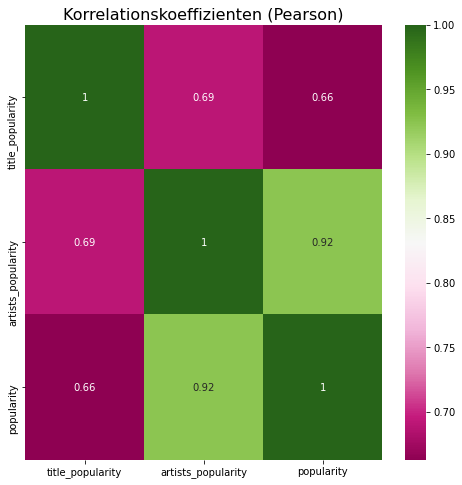

In [31]:
# Korrelationsmatrix
plt.figure(figsize = (8, 8))
ax = plt.axes()
sns.heatmap(df_prepro[['title_popularity', 'artists_popularity', 'popularity']].corr(), annot = True, cmap = 'PiYG', ax = ax)
ax.set_title('Korrelationskoeffizienten (Pearson)', size = 16)
plt.show()

Es fällt auf: Sowohl *'artists_popularity'* als auch *'title_popularity'* korrelieren deutlich mit der *'popularity'*. Das zeigt, das der Künstler selbst, aber auch der Titel einen Einfluss auf die Popularität eines Tracks haben. **Für die nachfolgenden Machine Learning Modelle werden die beiden Werte nicht verwendet, das sie auf Basis der Popularität berechnet wurden und somit die Target-Daten indirekt schon in den Trainingsdaten gegeben wären.** 

## Machine Learning

### Lineare Regression, Polynomische Regression, KNeighbors Regression und SVR im Vergleich

#### Daten als NumPy-Array

Der Datensatz wird in Inputdaten $X$ und Targetdaten $y$ aufgeteilt, welche in Form von NumPy-Arrays gespeichert werden.

In [32]:
# Import data
X = np.array(df_prepro.drop(['popularity', 'artists_popularity', 'title_popularity'], axis=1)) # Input-Daten
y = np.array(df_prepro['popularity']) # Target-Daten

#### Split in Trainings- und Testdaten

Input- und Trainingsdaten werden jeweils in 60 % Trainingsdaten und 40 % Testdaten aufgeteilt.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.6, random_state=42) # 60 % der Daten werden für das Training verwendet

#### Print-Funktion 'print_scores' für Evaluation der Vorhersagen

Die Funktion *print_metrics()* wird definiert. Bei Aufruf der Funktion werden die Qualitätsmetriken $RMSE$ (root mean squared error) und $R^2$ (Anteil an Varianz der Daten, der durch Modell erklärt wird) über einen Vergleich von Test-Daten und Vorhersagen berechnet und in die Konsole geschrieben.

In [34]:
# Funktion für die Evaluation der Vorhersagen
def print_metrics(y_true, preds, model_name=None):
    
    if model_name == None:
        print('RMSE: ', format(np.sqrt(mean_squared_error(y_true, preds))))
        print('R-Squared: ', format(r2_score(y_true, preds)))
        #print('\n\n')
    
    else:
        print('RMSE für ' + model_name + ' :' , format(np.sqrt(mean_squared_error(y_true, preds))))
        print('R-Squared für ' + model_name + ' :', format(r2_score(y_true, preds)))
        #print('\n\n')

#### Multiple lineare Regression

Das lineare Regressionsmodell ist das einfachste zu testende Modell, bei dem der Target-Wert über eine möglichst optimale Linearkombiation der Input-Werte gebildet wird.

In [35]:
# Fit des linearen Regressionsmodells
mlinear_regression = LinearRegression()
mlinear_regression.fit(X_train,y_train)
predictions = mlinear_regression.predict(X_test)
print_metrics(y_test, predictions, model_name = 'Multiple Lineare Regression')

RMSE für Multiple Lineare Regression : 0.10736950441011192
R-Squared für Multiple Lineare Regression : 0.7578720922895226


In [36]:
# Ausgabe der Fit-Koeffizienten a*valence+b*year+c*acousticness...
coeff_df = pd.DataFrame(mlinear_regression.coef_, df_prepro.drop(['popularity','artists_popularity', 'title_popularity'], axis=1).columns, columns=['Coefficient'])
coeff_df

,Coefficient
valence,0.005588
year,0.659581
acousticness,-0.042305
danceability,0.025414
duration_min,-0.001225
energy,-0.017828
explicit,0.009545
instrumentalness,-0.041919
key,0.000509
liveness,-0.028778


Das recht simple multiple lineare Regressionsmodell approximiert die Test-Daten bereits sehr gut:

<table>
  <thead>
    <tr>
      <th></th>
      <th>$RMSE$</th>
      <th>$R^2$</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Lineare Regression</td>
      <td>0.11</td>
      <td>0.76</td>
    </tr>
  </tbody>
</table>

#### Polynomische Regression

Bei der polynomischen Regression wird eine möglichst optimale Linearkombination von polynomischen Features gesucht. Dazu werden zunächst mit *PolynomialFeatures()* die Potenzen der Input-Werte bis zum Grad $n$ berechnet. Anschließend wird ein lineares Modell mit den polynomischen Features gefitted.

In [37]:
# Erstellung der polynomichen Features
poly_feat = PolynomialFeatures(degree = 4)
X_poly_train = poly_feat.fit_transform(X_train)
X_poly_test = poly_feat.fit_transform(X_test)
# Fit des linearen Regressionsmodells mit polynomischen Features
poly_regression = LinearRegression()
poly_regression.fit(X_poly_train,y_train)
predictions = poly_regression.predict(X_poly_test)
print_metrics(y_test, predictions, model_name = 'Polynomische Regression')

RMSE für Polynomische Regression : 0.10049885382802255
R-Squared für Polynomische Regression : 0.7878684967257354


Die polynomische Regression ist sehr zeitaufwändig für Ordnungen > 4. Für $n=4$  ist die Vorhersagegenauigkeit:

<table>
  <thead>
    <tr>
      <th></th>
      <th>$RMSE$</th>
      <th>$R^2$</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Polynomische Regression ($n=4$)</td>
      <td>0.10</td>
      <td>0.79</td>
    </tr>
  </tbody>
</table>

#### KNeighbors Regression (mit RandomizedSearchCV)

Bei dem KNeighbors Modell wird der Target-Wert der Test-Daten auf Basis eines (mit der Distanz) gewichteten Mittelwerts der Target-Werte der Trainings-Daten in der unmittelbaren Umgebung der Test-Daten ermittelt (Prinzip: Wahrscheinlichkeitsdichteschätzung). Mit der Funktion *RandomizedSearchCV()* werden unterschiedliche Kombinationen der Anzahl der nächsten Nachbarn ($n=5,10,15,30$) und der Gewichtung ($an/aus$) getestet.

In [38]:
knnr = KNeighborsRegressor()
#knnr.get_params()
param_dist = {'n_neighbors': [5, 10, 15, 30]}
              #,'weights': ['uniform','distance']} # Distance hat sich bewährt!
knnr_search = RandomizedSearchCV(knnr, param_distributions = param_dist, n_iter = 4)
knnr_search.fit(X_train,y_train)
predictions = knnr_search.best_estimator_.predict(X_test)
print_metrics(y_test, predictions, model_name = 'KNeighbours Regression')

RMSE für KNeighbours Regression : 0.10618259168842684
R-Squared für KNeighbours Regression : 0.7631956942395197


In [39]:
knnr_search.best_params_

{'n_neighbors': 30}

Das beste Modell ist das mit $n=30$ und *'distance'* Gewichtung. Es liefert gerundet die selbe Vorhersagegenauigkeit, wie das lineare Regressionsmodell. Die Genauigkeit wächst mit der Anzahl der Nachbarn, allerdings ist der Zuwachs ab $n=10$ nicht mehr sehr groß.

<table>
  <thead>
    <tr>
      <th></th>
      <th>$RMSE$</th>
      <th>$R^2$</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>KNeighbors ($k=30$)</td>
      <td>0.11</td>
      <td>0.76</td>
    </tr>
  </tbody>
</table>

#### Support Vector Machine (mit RandomizedSearchCV)

Eine Support Vector Machine unterteilt eine Menge von Objekten so in Klassen, dass um die Klassengrenzen herum ein möglichst breiter Bereich frei von Objekten bleibt; sie ist ein sogenannter Large Margin Classifier (dt. „Breiter-Rand-Klassifikator“)[https://de.wikipedia.org/wiki/Support_Vector_Machine]. Mit *RandomizedSearchCV()* werden unterschiedliche Parameter-Konfiguarationen für das Modell getestet.

In [40]:
svr = svm.SVR()
#svr.get_params()
#param_dist = {"C": [0.1, 0.5, 1, 3, 5],
#              "kernel": ['linear', 'poly', 'rbf', 'sigmoid']} # Teste verschiedene Kernel-Funktionen und C-Werte
param_dist = {"C":[1], "kernel":['rbf']} # Beste Parameter
#svr_search = RandomizedSearchCV(svr, param_distributions = param_dist, n_iter = 8)
svr_search = RandomizedSearchCV(svr, param_distributions = param_dist, n_iter = 1)
svr_search.fit(X_train,y_train)
predictions = svr_search.best_estimator_.predict(X_test)

In [41]:
svr_search.best_params_

{'kernel': 'rbf', 'C': 1}

In [42]:
print_metrics(y_test, predictions, model_name = 'SVR,kernel:rpf,C:1')

RMSE für SVR,kernel:rpf,C:1 : 0.10152465386793309
R-Squared für SVR,kernel:rpf,C:1 : 0.7835159086174622


Das SVR-Modell mit radial basis function kernel (*rpf*) die folgende Vorhersagegenauigkeit:

<table>
  <thead>
    <tr>
      <th></th>
      <th>$RMSE$</th>
      <th>$R^2$</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>SVR (rpf)</td>
      <td>0.10</td>
      <td>0.78</td>
    </tr>
  </tbody>
</table>

#### Kreuzvalidierung des linearen Modells

Für das lineare Modell wird eine Kreuzvalidierung durchgeführt mit 10 Durchgängen durchgeführt.

In [44]:
# Code aus Lektion 4k - CrossValidation, adaptiert für Regression
def draw_learning_curves(X, y, estimator, num_trainings):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=10, n_jobs=-1,
                                                           train_sizes = np.linspace(.1,1.0,num_trainings),
                                                            scoring = 'neg_root_mean_squared_error')
    train_scores_mean = np.mean(np.sqrt(-1*train_scores), axis = 1)
    train_scores_std = np.std(np.sqrt(-1*train_scores), axis = 1)
    test_scores_mean = np.mean(np.sqrt(-1*test_scores), axis = 1)
    test_scores_std = np.std(np.sqrt(-1*test_scores), axis = 1)
    
    plt.grid()
    
    plt.title('Learning Curves')
    plt.xlabel('Train Sizes')
    plt.ylabel('RMSE')
    
    plt.plot(train_scores_mean, 'o-', color = 'blue', label = 'training score')
    plt.plot(test_scores_mean, 'y-', color = 'green', label = 'cross validation score')
    
    plt.legend(loc = 'best')
    plt.show()

In [45]:
estimator = LinearRegression()

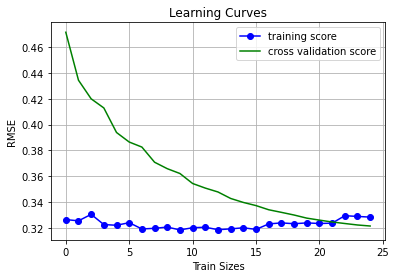

In [46]:
n_trainings = 25
draw_learning_curves(X, y, estimator, n_trainings)

In [49]:
print(f"Kreuzvalidierungs-RMSE für lineares Model (cv = 10): {np.mean(np.sqrt(-1*cross_val_score(estimator, X, y, cv=10, n_jobs = -1, scoring = 'neg_root_mean_squared_error')))}")

Kreuzvalidierungs-RMSE für lineares Model (cv = 10): 0.32157888237212245


Der RMSE, der aus der Kreuzvalidierung stammt ist größer als der RMSE aus dem einfachen Train/Test-Split. Dies ist ein Indikator für ein leichtes Overfitting des Modells.